In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input,Dense,Conv1D,Embedding,GlobalMaxPooling1D,MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
!ls

sample_data  spam.csv


In [2]:
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

--2022-08-08 11:44:58--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K   525KB/s    in 0.9s    

2022-08-08 11:45:00 (525 KB/s) - ‘spam.csv’ saved [503663/503663]



In [3]:
df = pd.read_csv('spam.csv',encoding='ISO-8859=1')


In [4]:
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)
df.columns = ['label','data']
df.head()

,label,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:

df['b_label'] = df['label'].map({'ham':0,'spam':1})
Y = df['b_label'].values

X_train,X_test,y_train,y_test = train_test_split(df['data'],Y,test_size=0.33)

In [6]:
max_vocab = 20000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)
seq_train = tokenizer.texts_to_sequences(X_train)
seq_test = tokenizer.texts_to_sequences(X_test)

In [7]:
V = len(tokenizer.index_word)
dt_train = pad_sequences(seq_train)
T = dt_train.shape[1]
dt_test = pad_sequences(seq_test,maxlen=T)


In [8]:
D = 20
i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Conv1D(32, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)

x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)

In [9]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)
with tf.device('/device:GPU:0'):
  r = model.fit(dt_train,y_train,epochs=5,validation_data=(dt_test,y_test),steps_per_epoch=len(dt_train))

Epoch 1/5
3733/3733 [==============================] - 29s 4ms/step - loss: 0.1464 - accuracy: 0.9510 - val_loss: 0.0456 - val_accuracy: 0.9886
Epoch 2/5
3733/3733 [==============================] - 15s 4ms/step - loss: 0.0253 - accuracy: 0.9933 - val_loss: 0.0516 - val_accuracy: 0.9869
Epoch 3/5
3733/3733 [==============================] - 16s 4ms/step - loss: 0.0111 - accuracy: 0.9968 - val_loss: 0.0686 - val_accuracy: 0.9891
Epoch 4/5
3733/3733 [==============================] - 15s 4ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.1034 - val_accuracy: 0.9891
Epoch 5/5
3733/3733 [==============================] - 15s 4ms/step - loss: 0.0029 - accuracy: 0.9989 - val_loss: 0.0897 - val_accuracy: 0.9880


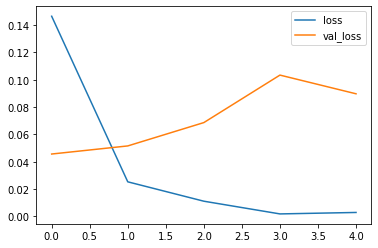

In [10]:
plt.plot(r.history['loss'],label ='loss')
plt.plot(r.history['val_loss'],label ='val_loss')
plt.legend()

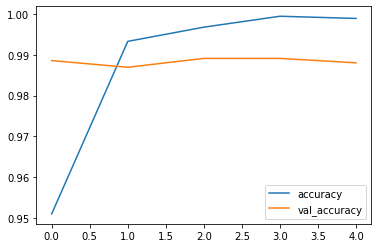

In [11]:
plt.plot(r.history['accuracy'],label ='accuracy')
plt.plot(r.history['val_accuracy'],label ='val_accuracy')
plt.legend()

In [12]:
y_pred = model.predict(dt_test).argmax(axis=1)


In [13]:
miss_idx = np.where(y_pred != y_test)[0]
miss_idx

array([   1,   12,   26,   28,   30,   41,   59,   79,   80,   90,  102,
        106,  114,  115,  118,  149,  150,  159,  167,  190,  199,  201,
        202,  213,  216,  223,  232,  244,  250,  251,  257,  258,  264,
        268,  272,  279,  298,  299,  319,  326,  340,  346,  350,  356,
        357,  367,  369,  388,  409,  418,  419,  428,  438,  449,  455,
        465,  467,  478,  481,  485,  488,  494,  528,  567,  571,  572,
        575,  600,  607,  614,  621,  624,  631,  635,  642,  655,  656,
        657,  660,  665,  677,  688,  700,  724,  747,  749,  753,  759,
        763,  765,  781,  782,  784,  785,  792,  809,  812,  820,  849,
        850,  868,  872,  874,  910,  912,  913,  914,  921,  922,  946,
        960,  962,  971, 1001, 1011, 1013, 1025, 1026, 1038, 1044, 1053,
       1054, 1060, 1072, 1093, 1095, 1099, 1112, 1116, 1132, 1146, 1151,
       1157, 1158, 1161, 1170, 1173, 1176, 1178, 1185, 1199, 1204, 1206,
       1212, 1216, 1222, 1224, 1233, 1236, 1242, 12

In [30]:

#i = np.random.choice(miss_idx)
for i in miss_idx:
  print('True value: %s  Predicted value: %s' %(y_test[i], y_pred[i]))
  #print('Predicted value: %s' %y_pred[i])
  print('Data: %s' %X_test.iloc[i])
  


True value: 1  Predicted value: 0
Data: 1000's flirting NOW! Txt GIRL or BLOKE & ur NAME & AGE, eg GIRL ZOE 18 to 8007 to join and get chatting!
True value: 1  Predicted value: 0
Data: ree entry in 2 a weekly comp for a chance to win an ipod. Txt POD to 80182 to get entry (std txt rate) T&C's apply 08452810073 for details 18+
True value: 1  Predicted value: 0
Data: PRIVATE! Your 2003 Account Statement for 07808 XXXXXX shows 800 un-redeemed S. I. M. points. Call 08719899217 Identifier Code: 41685 Expires 07/11/04
True value: 1  Predicted value: 0
Data: GSOH? Good with SPAM the ladies?U could b a male gigolo? 2 join the uk's fastest growing mens club reply ONCALL. mjzgroup. 08714342399.2stop reply STOP. msg@å£1.50rcvd
True value: 1  Predicted value: 0
Data: FREE camera phones with linerental from 4.49/month with 750 cross ntwk mins. 1/2 price txt bundle deals also avble. Call 08001950382 or call2optout/J MF
True value: 1  Predicted value: 0
Data: A link to your picture has been sent. You

In [ ]:
len(y_test)

1839

In [ ]:
len(y_pred)

1839

In [ ]:
i


1650

In [ ]:
df.iloc[i][0]

'spam'

In [13]:
dt_train.shape

(3733, 189)

In [14]:
dt_test.shape

(1839, 189)

In [38]:
len(y_pred)

1839

In [47]:
X_test.sort_index()

(1839,)

In [43]:
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [48]:
X_test[5]

"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv"

In [17]:
X_test.iloc[1]

"1000's flirting NOW! Txt GIRL or BLOKE & ur NAME & AGE, eg GIRL ZOE 18 to 8007 to join and get chatting!"

In [19]:
y_test[1]

1

In [20]:
df.iloc[1]

label                                ham
data       Ok lar... Joking wif u oni...
b_label                                0
Name: 1, dtype: object

In [22]:
y_pred.sum()

0

In [26]:
(df.b_label == 0).sum()

4825